### **MODEL 2**
# **Q-LEARNING**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Augmentor

In [ ]:
from google.colab import files
uploaded = files.upload()

# Use the following code to uploade necessary modules
!ls

Saving QLearningModule.py to QLearningModule.py
drive  QLearningModule.py  sample_data


### **QLAgent Model**

In [ ]:
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score
from itertools import combinations
from sklearn.datasets import load_iris
import EnvModule
from EnvModule import RunModel, MLModelSelector, METHODS_ACTIONS, ALGORITHM_METHODS
import warnings
from sklearn.exceptions import ConvergenceWarning  # Ignore ConvergenceWarnings
# Ignore specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Ignore FutureWarnings
warnings.filterwarnings('ignore', category=UserWarning)    # Ignore UserWarnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)  # Ignore ConvergenceWarnings


# Load the dataset
from sklearn.datasets import load_iris
iris = load_iris()
data, labels = iris.data, iris.target

# Q-Learning Agent Class
class QLearningAgent:
    def __init__(self, num_actions, learning_rate=0.1, discount_factor=0.9, initial_epsilon=1.0, epsilon_decay=0.995):
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros(num_actions)

    def select_action(self):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        return np.argmax(self.q_table)

    def update_q_table(self, action, reward):
        self.q_table[action] += self.learning_rate * (reward - self.q_table[action])
        self.epsilon *= self.epsilon_decay

# Feature Engineering Environment Class
class FeatureEngineeringEnvironment:
    def __init__(self, data, labels, model, feature_methods, max_steps=10):
        self.data = data
        self.labels = labels
        self.model = model
        self.feature_methods = feature_methods
        self.max_steps = max_steps
        self.current_step = 0
        self.current_accuracy = 0
        self.base_accuracy = self.evaluate_model(data, labels)

    def evaluate_model(self, data, labels, num_folds=5):
        train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
        self.model.fit(train_data, train_labels)
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        scores = cross_val_score(self.model, data, labels, cv=num_folds)
        return np.mean(scores)

    def apply_feature_method(self, method_name, data):
        # Suppress warnings within this method
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Apply the feature method(s) to the data
            if isinstance(method_name, list):
                # If method_name is a list, iterate through each method in the list and apply it
                for m in method_name:
                    if m in METHODS_ACTIONS:
                        data = METHODS_ACTIONS[m](data)
                    else:
                        raise ValueError(f"Method {m} not found in METHODS_ACTIONS")
            else:
                # If method_name is a single string (not a list), apply the method directly
                if method_name in METHODS_ACTIONS:
                    data = METHODS_ACTIONS[method_name](data)
                else:
                    raise ValueError(f"Method {method_name} not found in METHODS_ACTIONS")
            return data

    def step(self, action_index):
        if self.current_step >= self.max_steps:
            return None, 0, True

        # Apply the feature method corresponding to the action index
        method_name = self.feature_methods[action_index]
        processed_data = self.apply_feature_method([method_name], self.data)  # Apply a single method
        new_accuracy = self.evaluate_model(processed_data, self.labels)
        self.current_step += 1

        # Calculate reward based on improvement in accuracy
        reward = new_accuracy - self.current_accuracy
        self.current_accuracy = new_accuracy

        done = self.current_step >= self.max_steps
        return processed_data, reward, done

    def reset(self):
        self.current_step = 0
        self.current_accuracy = self.base_accuracy
        self.data = iris.data  # Reset to original data

# Initialize model selector and Q-learning environment
problem_type = "Prediction(multi-outcome)"
model_selector = MLModelSelector(problem_type=problem_type)
selected_algorithm = model_selector.algorithm_selector()
model = RunModel(selected_algorithm).algorithm_processor()
feature_methods_dict = ALGORITHM_METHODS[selected_algorithm]
feature_methods = list(feature_methods_dict.keys())

# Initialize Q-learning agent and lists for tracking progress
num_actions = len(feature_methods)
q_agent = QLearningAgent(num_actions)
episode_accuracies = []
best_accuracy_global = 0.0

# Training loop with progress updates
print("Q-Learning Agent is Looking for Best Combination...")
best_methods = []
num_episodes = 1000

for episode in range(num_episodes):
    # Update on progress every 100 episodes
    if episode % 100 == 0:
        print(f"Processing episode {episode}...")

    env = FeatureEngineeringEnvironment(data, labels, model, feature_methods)
    env.reset()
    episode_best_accuracy = 0.0  # Initialize episode best accuracy
    done = False

    while not done:
        action = q_agent.select_action()
        _, reward, done = env.step(action)
        q_agent.update_q_table(action, reward)

    # Identify best-performing methods based on Q-table
    top_methods_indices = np.argsort(-q_agent.q_table)[:3]  # Top 3 methods
    top_methods = [feature_methods[i] for i in top_methods_indices]

    # Evaluate combinations of top methods
    for combo in combinations(top_methods, r=2):  # Evaluate pairs of top methods
        combo_data = data.copy()
        for method_name in combo:
            combo_data = env.apply_feature_method(method_name, combo_data)
        combo_accuracy = env.evaluate_model(combo_data, labels)
        if combo_accuracy > episode_best_accuracy:
            episode_best_accuracy = combo_accuracy

            # Update best accuracy and best methods
            if episode_best_accuracy > best_accuracy_global:
                best_accuracy_global = episode_best_accuracy
                best_methods = combo
                print(f"Best combination found: {best_methods} with accuracy: {best_accuracy_global}")

    # Store the best accuracy for this episode
    episode_accuracies.append(episode_best_accuracy)

Q-Learning Agent is Looking for Best Combination...
Processing episode 0...
Best combination found: ('singular_value_decomposition', 'feature_agglomeration') with accuracy: 0.96
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-negative.
Negative values found. S

In [ ]:
# Print best accuracy
print(f"Best global accuracy achieved: {best_accuracy_global}")
print(f"Best combination found: {best_methods} with accuracy: {best_accuracy_global}")

Best global accuracy achieved: 0.9600000000000002
Best combination found: ('non_negative_matrix_factorization', 'singular_value_decomposition') with accuracy: 0.9600000000000002


# **QLAgent Visualization**

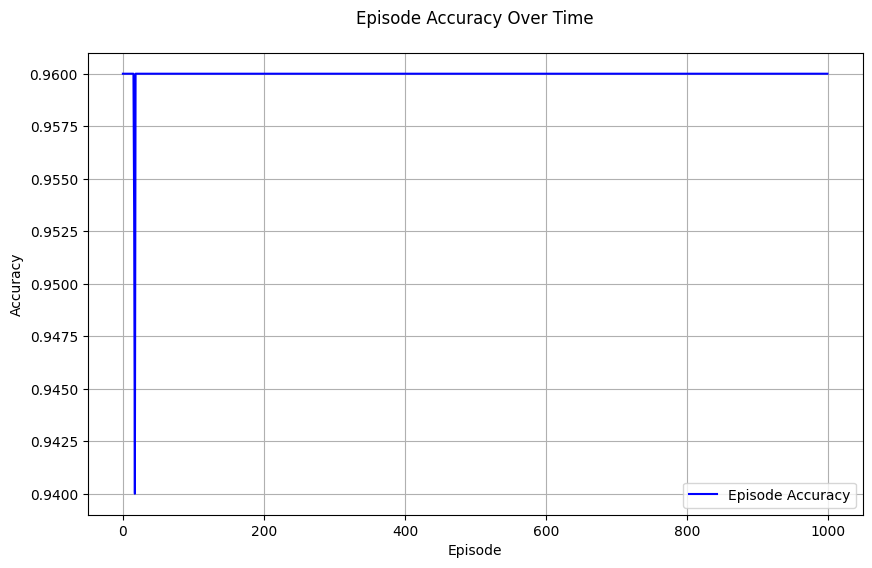




------------------------------------------------------------------------------------------------------------------


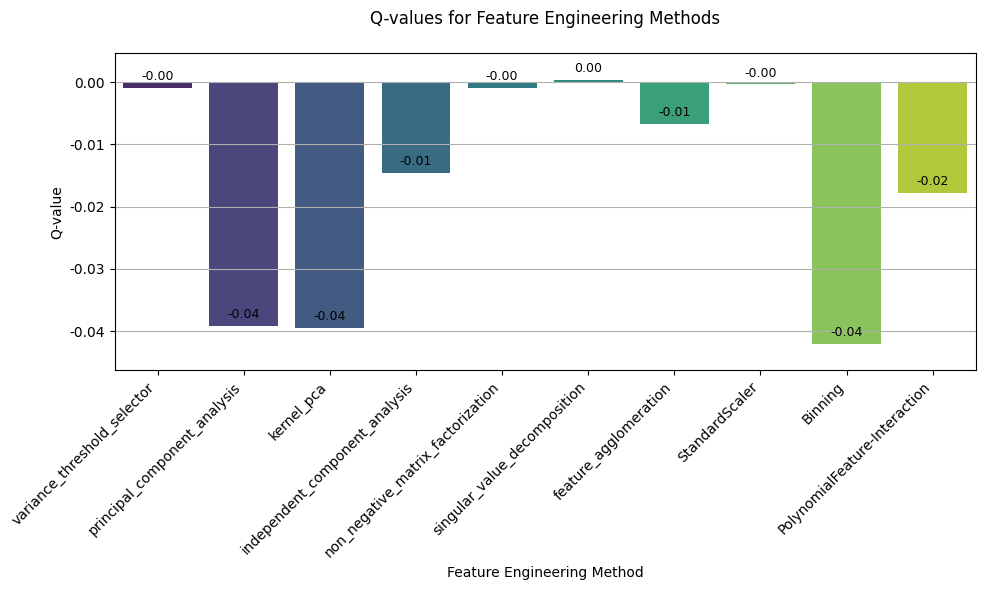




------------------------------------------------------------------------------------------------------------------


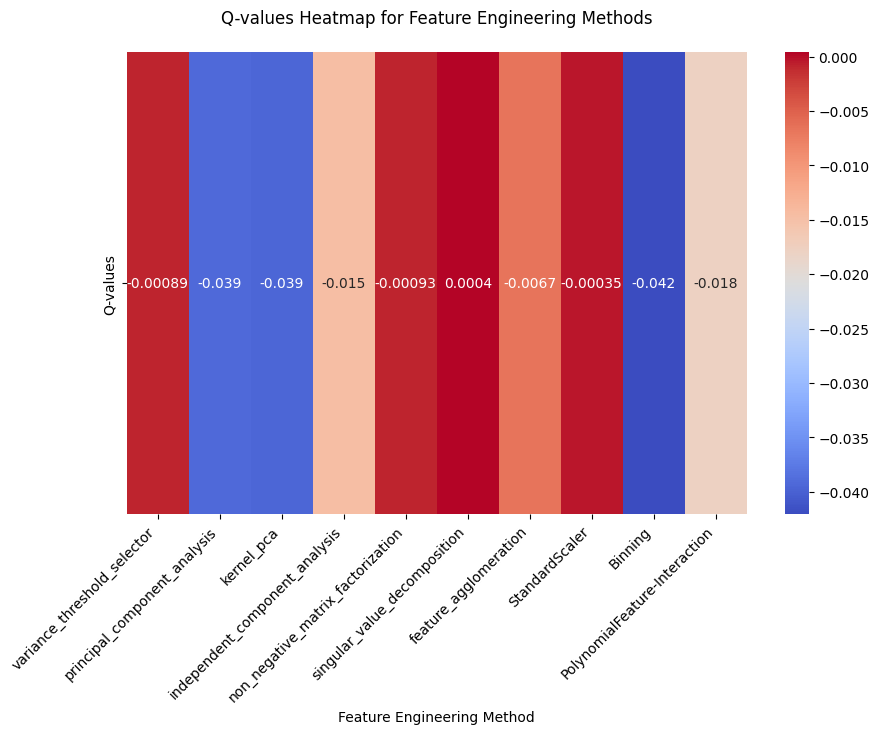




------------------------------------------------------------------------------------------------------------------


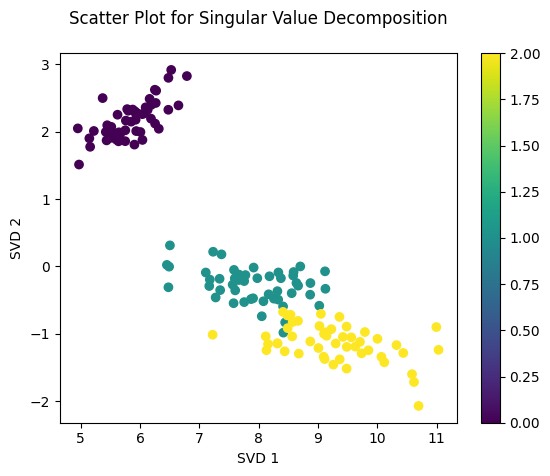




------------------------------------------------------------------------------------------------------------------


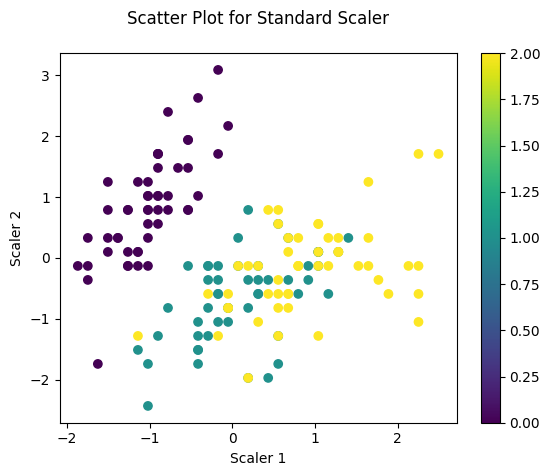

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# Episode accuracies over time
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), episode_accuracies, label='Episode Accuracy', color='b')
plt.xlabel('Episode')
plt.ylabel('Accuracy')
plt.title('Episode Accuracy Over Time\n')
plt.legend()
plt.grid(True)
plt.show()
print("\n\n")
print("------------------------------------------------------------------------------------------------------------------")

# Q-values for Feature Engineering Methods
q_values = q_agent.q_table.flatten()

# Calculate the range of Q-values and set a buffer as a percentage of this range
q_value_range = max(q_values) - min(q_values)
buffer = 0.1 * q_value_range
y_min = min(q_values) - buffer if min(q_values) < 0 else min(q_values) * 0.9
y_max = max(q_values) + buffer
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=feature_methods, y=q_values, palette='viridis', ci=None)
plt.ylim(y_min, y_max)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                 bar.get_height()), ha='center', va='center',
                 size=9, xytext=(0, 8),
                 textcoords='offset points')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2f}'.format(y)))

plt.xlabel('Feature Engineering Method')
plt.ylabel('Q-value')
plt.title('Q-values for Feature Engineering Methods\n')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
print("\n\n")
print("------------------------------------------------------------------------------------------------------------------")

# Heatmap to visualize the Q-values as a matrix
q_matrix = q_agent.q_table.reshape(1, -1)
plt.figure(figsize=(10, 6))
sns.heatmap(q_matrix, annot=True, cmap='coolwarm', xticklabels=feature_methods, yticklabels=['Q-values'])
plt.xlabel('Feature Engineering Method')
plt.title('Q-values Heatmap for Feature Engineering Methods\n')
plt.xticks(rotation=45, ha='right')
plt.show()
print("\n\n")
print("------------------------------------------------------------------------------------------------------------------")

# Best Feature Method 1: Singular Value Decomposition
svd = TruncatedSVD(n_components=2)
svd_result = svd.fit_transform(data)

plt.scatter(svd_result[:, 0], svd_result[:, 1], c=labels)
plt.title('Scatter Plot for Singular Value Decomposition\n')
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.colorbar()
plt.show()
print("\n\n")
print("------------------------------------------------------------------------------------------------------------------")

# Best Feature Method 2: Standard Scaler
scaler = StandardScaler()
scaler_result = scaler.fit_transform(data)

plt.scatter(scaler_result[:, 0], scaler_result[:, 1], c=labels)
plt.title('Scatter Plot for Standard Scaler\n')
plt.xlabel('Scaler 1')
plt.ylabel('Scaler 2')
plt.colorbar()
plt.show()